[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kentaojapi/dataanalysis_tgs-salt/blob/master/20181012_13_kaggle_salt.ipynb)

In [71]:
# download API key from google drive
## Original: https://colab.research.google.com/drive/1eufc8aNCdjHbrBhuy7M7X6BGyzAyRbrF#scrollTo=y5_288BYp6H1
## When you run for the first time, you will see a link to authenticate.

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)


Download 100%.


In [72]:
!ls

27th-model1-tgs-salt-20181015191049.h5	depths.csv   sample_submission.csv
28th-model1-tgs-salt-20181015211021.h5	drive	     test
28th-model1-tgs-salt-20181016001018.h5	masks	     train
adc.json				sample_data  train.csv


In [0]:
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle competitions download -c tgs-salt-identification-challenge
!unzip train.zip
!mv images/ train/
!unzip test.zip
!mv images/ test/
!rm train.zip
!rm test.zip
!df -h
from IPython.display import clear_output
clear_output()

In [0]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Add, multiply, Multiply, RepeatVector, Reshape
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf


from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
t_start = time.time()

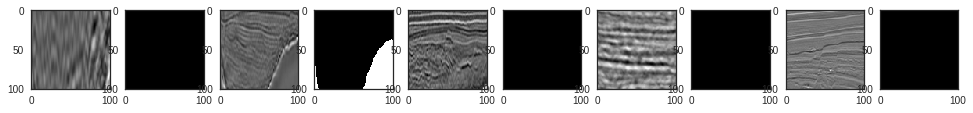

In [7]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('../content/train/' + img_name + '.png')
    img_mask = load_img('../content/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [0]:
img_size_ori = 101
img_size_target = 101
n_features = 1

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [74]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("../content/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../content/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)


4000

In [100]:
test_df.head()

,z
id,
353e010b7b,264
5439dbbddf,557
71bab9f311,846
52551f7a80,610
512d8d9997,577


In [76]:
train_df["images"] = [np.array(load_img("../content/train/{}.png".format(idx), grayscale=True)) / 255 for idx in train_df.index]
train_df["masks"] = [np.array(load_img("../content/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in train_df.index]
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

train_df.head()

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


In [101]:
# depth data
X_feat = np.zeros((len(train_df.index.values), n_features), dtype=np.float32)
for n, id_ in enumerate(train_df.index.values):
  X_feat[n] = train_df.loc[id_, 'z']
  
X_feat

array([[843.],
       [794.],
       [468.],
       ...,
       [177.],
       [221.],
       [460.]], dtype=float32)

In [103]:
X_feat_test = np.zeros((len(test_df.index.values), n_features), dtype=np.float32)
for n, id_ in enumerate(test_df.index.values):
  X_feat_test[n] = test_df.loc[id_, 'z']

X_feat_test
#print(X_feat.shape)

array([[264.],
       [557.],
       [846.],
       ...,
       [605.],
       [309.],
       [532.]], dtype=float32)

Text(0.5,0,'Coverage class')

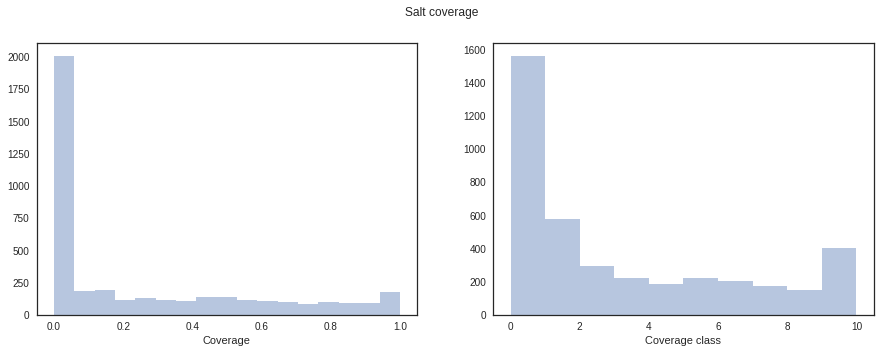

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0.5,1,'Depth distribution')

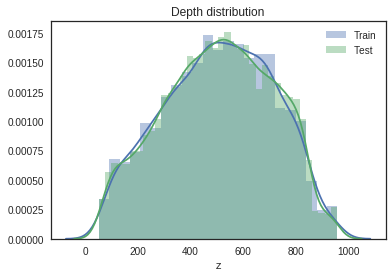

In [11]:
#Plotting the depth distributions¶
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [0]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, X_feat_train, X_feat_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    X_feat,
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

In [0]:
# Normalize X_feat
x_feat_mean = X_feat_train.mean(axis=0, keepdims=True)
x_feat_std = X_feat_train.std(axis=0, keepdims=True)
X_feat_train -= x_feat_mean
X_feat_train /= x_feat_std

X_feat_valid -= x_feat_mean
X_feat_valid /= x_feat_std

In [0]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
        #x = Dropout(0.5)(x) #add
    return x

# def se_block(x, filters):
#     x = AveragePooling2D(pool_size=(FIELD_SIZE, FIELD_SIZE))(x)
#     x = Conv2D(filters, (1, 1))(x)
#     x = Activation("relu")(x)
#     x = Conv2D(128, (1, 1))(x)
#     x = Activation("sigmoid")(x)
#     x = UpSampling2D(size=(FIELD_SIZE, FIELD_SIZE))(x)
#     x = 
#     return x
    
def se_block(input_tensor, compress_rate = 16):
    num_channels = int(input_tensor.shape[-1]) # Tensorflow backend
    bottle_neck = int(num_channels//compress_rate)
    se_branch = GlobalAveragePooling2D()(input_tensor)
    se_branch = Dense(bottle_neck, activation='relu')(se_branch)
    se_branch = Dense(num_channels, activation='sigmoid')(se_branch)
    x = input_tensor 
    out = multiply([x, se_branch])
    return out

def cse_block(prevlayer):
    mean = Lambda(lambda xin: K.mean(xin, axis=[1, 2]))(prevlayer)
    lin1 = Dense(K.int_shape(prevlayer)[3]//2, activation='relu')(mean)
    lin2 = Dense(K.int_shape(prevlayer)[3], activation='sigmoid')(lin1)
    x = Multiply()([prevlayer, lin2])
    return x

def sse_block(prevlayer):
    conv = Conv2D(1, (1, 1), padding="same", kernel_initializer="he_normal", 
                  activation='sigmoid', strides=(1, 1))(prevlayer)
    conv = multiply([prevlayer, conv])
    return conv

def csse_block(x):
    '''
    Implementation of Concurrent Spatial and Channel ‘Squeeze & Excitation’ in Fully Convolutional Networks
    https://arxiv.org/abs/1803.02579
    '''
    cse = cse_block(x)
    sse = sse_block(x)
    x = Add()([cse, sse])
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    #x = se_block(x)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [0]:
# Build model
def build_model(input_img, input_features, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_img)
    conv1 = residual_block(conv1, start_neurons * 1)
    conv1 = residual_block(conv1, start_neurons * 1, True)
    conv1 = csse_block(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    conv2 = csse_block(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)
    
    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    conv3 = csse_block(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    conv4 = csse_block(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)
    
    # Join features information in the depthest layer
    f_repeat = RepeatVector(6*6)(input_features)
    f_conv = Reshape((6, 6, n_features))(f_repeat)
    pool4_depth = concatenate([pool4, f_conv], -1)
                                  
    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4_depth)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    uconv4 = csse_block(uconv4)


    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    uconv3 = csse_block(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)
    uconv3 = csse_block(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    uconv4 = csse_block(uconv4)
                                  
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    uconv1 = csse_block(uconv1)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [0]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [0]:
# from keras import backend as K
# '''
# Compatible with tensorflow backend
# '''
# def focal_loss_fixed(y_true, y_pred, gamma=2., alpha=.25):
#   pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#   pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#   return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


In [0]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        #loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        loss = tf.tensordot(tf.nn.elu(errors_sorted)+1, tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [85]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

(6400, 101, 101, 1)
(800, 101, 101, 1)


In [86]:
X_feat_train = np.append(X_feat_train, X_feat_train, axis=0)
print(X_feat_train.shape)

(6400, 1)


In [87]:
# model1
input_img = Input((img_size_target, img_size_target, 1), name='img')
input_features = Input((n_features, ), name='feat')
output_layer = build_model(input_img, input_features, 16, 0.5)

model1 = Model(inputs=[input_img, input_features], outputs=output_layer)

#c = optimizers.adam(lr = 0.01)
c = optimizers.Nadam(lr=0.01)
#c = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model1.compile(loss='binary_crossentropy', optimizer=c, metrics=[my_iou_metric])
#model1.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric])

model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_190 (Conv2D)             (None, 101, 101, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_156 (BatchN (None, 101, 101, 16) 64          conv2d_190[0][0]                 
__________________________________________________________________________________________________
activation_159 (Activation)     (None, 101, 101, 16) 0           batch_normalization_156[0][0]    
__________________________________________________________________________________________________
conv2d_191

In [0]:
class ModelSave(ModelCheckpoint):
    def __init__(self, filepath, verbose=0, save_freq=25):
        super(ModelSave, self).__init__(filepath, verbose=verbose)
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.save_freq == 0:
            times = epoch / self.save_freq 
            model1.save("drive/My Drive/kaggle/{0}times-{1}".format(times, self.filepath))

In [70]:
#1st-25epochs
import datetime
now = datetime.datetime.now().strftime('%Y%m%d%H%m%S')
save_file = '28th-model1-tgs-salt-{}.h5'.format(now)

from google.colab import drive
drive.mount('/content/drive')
file_name = '1.0times-28th-model1-tgs-salt-20181016001018.h5'


early_stopping = EarlyStopping(monitor='my_iou_metric', mode='max', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_file, monitor='my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode='max', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
save_model =ModelSave(filepath=save_file)

epochs = 100
#epochs = 25
batch_size = 32

history = model1.fit({'img':x_train, 'feat':X_feat_train}, y_train,
                    validation_data=({'img':x_valid, 'feat':X_feat_valid}, y_valid), 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr, save_model], 
                    verbose=2)

model1.save("drive/My Drive/kaggle/{}".format(save_file))


Mounted at /content/drive
Train on 6400 samples, validate on 800 samples
Epoch 1/100
 - 123s - loss: 0.0878 - my_iou_metric: 0.7911 - val_loss: 0.1373 - val_my_iou_metric: 0.7699

Epoch 00001: my_iou_metric improved from -inf to 0.79109, saving model to 28th-model1-tgs-salt-20181016001018.h5
Epoch 2/100
 - 105s - loss: 0.0840 - my_iou_metric: 0.7965 - val_loss: 0.1540 - val_my_iou_metric: 0.7666

Epoch 00002: my_iou_metric improved from 0.79109 to 0.79650, saving model to 28th-model1-tgs-salt-20181016001018.h5
Epoch 3/100
 - 105s - loss: 0.0864 - my_iou_metric: 0.7950 - val_loss: 0.1372 - val_my_iou_metric: 0.7621

Epoch 00003: my_iou_metric did not improve from 0.79650
Epoch 4/100
 - 105s - loss: 0.0855 - my_iou_metric: 0.7965 - val_loss: 0.1312 - val_my_iou_metric: 0.7728

Epoch 00004: my_iou_metric did not improve from 0.79650
Epoch 5/100
 - 105s - loss: 0.0812 - my_iou_metric: 0.7978 - val_loss: 0.1522 - val_my_iou_metric: 0.7297

Epoch 00005: my_iou_metric improved from 0.79650 to

KeyboardInterrupt: ignored

In [89]:
  #1st-25epochs
import datetime
now = datetime.datetime.now().strftime('%Y%m%d%H%m%S')
save_file = '4.0times-28th-model1-tgs-salt-{}.h5'.format(now)

from google.colab import drive
drive.mount('/content/drive')
file_name = '1.0times-28th-model1-tgs-salt-20181016001018.h5'
model1 = load_model('drive/My Drive/kaggle/{}'.format(file_name),
                   custom_objects={'my_iou_metric': my_iou_metric})

early_stopping = EarlyStopping(monitor='my_iou_metric', mode='max', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_file, monitor='my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode='max', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
save_model =ModelSave(filepath=save_file)

#epochs = 100
epochs = 50
batch_size = 32

history = model1.fit({'img':x_train, 'feat':X_feat_train}, y_train,
                    validation_data=({'img':x_valid, 'feat':X_feat_valid}, y_valid), 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr, save_model], 
                    verbose=2)

model1.save("drive/My Drive/kaggle/{}".format(save_file))

Mounted at /content/drive
Train on 6400 samples, validate on 800 samples
Epoch 1/50
 - 124s - loss: 0.0627 - my_iou_metric: 0.8137 - val_loss: 0.1605 - val_my_iou_metric: 0.7800

Epoch 00001: my_iou_metric improved from -inf to 0.81369, saving model to 4.0times-28th-model1-tgs-salt-20181016011017.h5
Epoch 2/50
 - 106s - loss: 0.0605 - my_iou_metric: 0.8216 - val_loss: 0.1485 - val_my_iou_metric: 0.7679

Epoch 00002: my_iou_metric improved from 0.81369 to 0.82164, saving model to 4.0times-28th-model1-tgs-salt-20181016011017.h5
Epoch 3/50
 - 106s - loss: 0.0595 - my_iou_metric: 0.8177 - val_loss: 0.1602 - val_my_iou_metric: 0.7718

Epoch 00003: my_iou_metric did not improve from 0.82164
Epoch 4/50
 - 106s - loss: 0.0617 - my_iou_metric: 0.8166 - val_loss: 0.1333 - val_my_iou_metric: 0.7876

Epoch 00004: my_iou_metric did not improve from 0.82164
Epoch 5/50
 - 106s - loss: 0.0584 - my_iou_metric: 0.8197 - val_loss: 0.1299 - val_my_iou_metric: 0.7890

Epoch 00005: my_iou_metric did not imp

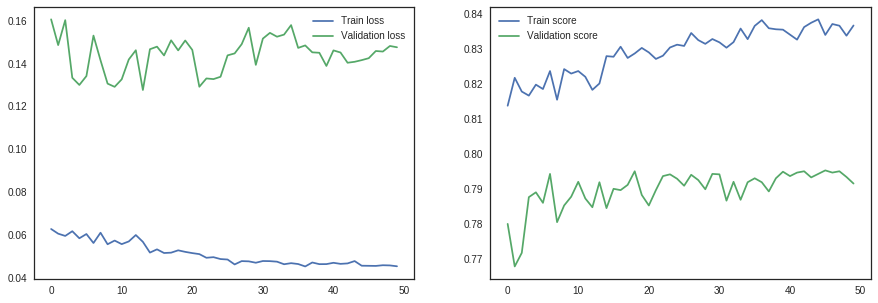

In [90]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()

In [0]:
# 2nd
from google.colab import drive
drive.mount('/content/drive')
#file_name =  '3.0times-20th-25epochs-model1-tgs-salt-20181013081000.h5'

#model1 = load_model('drive/My Drive/kaggle/{}'.format(file_name), custom_objects={'my_iou_metric': my_iou_metric})
# remove layter activation layer and use losvasz loss
input_x = model1.layers[0].input

output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
#c = optimizers.adam(lr = 0.01)
c = optimizers.Nadam(lr=0.002)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

model.summary()

In [0]:
#2nd ~125epochs
import datetime
now = datetime.datetime.now().strftime('%Y%m%d%H%m%S')
save_file = '24th-model-tgs-salt-{}.h5'.format(now)

from google.colab import drive
drive.mount('/content/drive')

# early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max', patience=16, verbose=1)
model_checkpoint = ModelCheckpoint(save_file, monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)
save_model = ModelSave(filepath=save_file)

epochs = 50
batch_size = 32
#epochs = 100
#batch_size = 128

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr, save_model], 
                    verbose=2)

model.save("drive/My Drive/kaggle/{}".format(save_file))

In [0]:
#2nd 50epochs
import datetime
now = datetime.datetime.now().strftime('%Y%m%d%H%m%S')
save_file = '13th-model-50epochs-tgs-salt-Nadam-{}.h5'.format(now)

from google.colab import drive
drive.mount('/content/drive')
file_name = '13th-model-25epochs-tgs-salt-Nadam-20181010131009.h5'
model = load_model('drive/My Drive/kaggle/{}'.format(file_name),
                   custom_objects={'my_iou_metric_2': my_iou_metric_2, 'lovasz_loss': lovasz_loss})

# early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max', patience=16, verbose=1)
model_checkpoint = ModelCheckpoint(save_file, monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)

epochs = 25
batch_size = 32
#epochs = 100
#batch_size = 128

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=2)

model.save("drive/My Drive/kaggle/{}".format(save_file))

In [0]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [0]:
def predict_result(model,x_test, X_feat_valid, img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    X_feat_test = np.append(X_feat_test, X_feat_test, axis=0)
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [93]:
preds_valid = predict_result(model1, x_valid, X_feat_valid, img_size_target)
#preds_valid = predict_result(model, x_valid, img_size_target)

ValueError: ignored

In [0]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
    #temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [95]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in thresholds])
print(ious)

NameError: ignored

In [96]:
# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

NameError: ignored

In [0]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [0]:
x_test = np.array([(np.array(load_img("../content/test/{}.png".format(idx), grayscale = True))) / 255 for idx in test_df.index]).reshape(-1, img_size_target, img_size_target, 1)

In [99]:
preds_test = predict_result(model1, x_test,img_size_target)
#preds_test = predict_result(model, x_test,img_size_target)

ValueError: ignored

In [0]:
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(test_df.index.values)}

In [0]:
import datetime
now = datetime.datetime.now().strftime('%Y%m%d%H%m%S')
submit_name = '26th-model1-tgs-salt-submission_{}.csv'.format(now)
#submit_name = '25th-model-tgs-salt-submission_{}.csv'.format(now)


sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submit_name)

In [33]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")

Kernel run time = 3.014850906663471 hours


In [34]:
!cp "../content/$submit_name" "drive/My Drive/kaggle/"
!kaggle competitions submit -c tgs-salt-identification-challenge -f "drive/My Drive/kaggle/$submit_name" -m "$now"


Successfully submitted to TGS Salt Identification Challenge